In [1]:
! pip install datasets xgboost --q

In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
warnings.filterwarnings (action = 'ignore')
pd.set_option('display.MAX_COLUMNS', None)

In [3]:
from datasets import load_dataset
dataset = load_dataset("Mireu-Lab/NSL-KDD")

In [210]:
train_data = dataset['train'].to_pandas()
test_data1 = dataset['test'].to_pandas()

# Feature Engineering

In [11]:
def feat_gen(data):
    # 1. Traffic Volume & Connection Statistics
    data['avg_duration_per_host'] = data.groupby('dst_host_count')['duration'].transform('mean') # Avg duration per host
    data['conn_rate'] = data['count'] / (data['duration']+1)   # connection rate per second
    data['bytes_ratio'] = data['src_bytes']/(data['dst_bytes']+1) # traffic volumne ratio (high traffic : attack)

    #2. Attack pattern Indicators
    data['failed_login_rate'] = data['num_failed_logins']/(data['count']+1) # failed login rate
    data['error_ratio'] = data['serror_rate']/(data['srv_serror_rate']+1) #error rate ratio
    data['rerror_ratio'] = data['rerror_rate']/(data['srv_rerror_rate']+1) #response anomaly : distinguish between normal and attack traffic
    
    #3. User behavior
    data['is_guest_access'] = data['is_guest_login'].apply( lambda x:1 if x ==1 else 0) # check if guest login
    data['shell_access_rate'] = data['num_shells']/(data['num_access_files']+1) #detect root level attacks
    data['privilege_abuse_score'] = data['num_file_creations']/(data['num_root']+1) # root privilege

    #4. Time based usage 
    # traffic in last 10 sec and last 1 min
    # data['count_10s'] = data.groupby('dst_host_count')['count'].transform(lambda x: x.rolling(10, min_periods = 1).sum())
    # data['count_1m'] = data.groupby('dst_host_count')['count'].transform(lambda x: x.rolling(60, min_periods = 1).sum())
    # data['traffic_spike'] = data['count_10s'] / (data['count_1m'] + 1)
    #data['error_change'] = data.groupby('dst_host_count')['serror_rate'].transform(lambda x: x.pct_change()) #Error Rate Change (Sudden increase in errors over time)

    #5. CATEGORICAL FEATURE ENCODING 
    protocol_order = {'icmp': 0, 'udp': 1, 'tcp': 2}
    data['protocol_type'] = data['protocol_type'].map(protocol_order)
    
    service_counts = data['service'].value_counts(normalize=True)
    data['service_encoded'] = data['service'].map(service_counts)
    
    flag_order = {'SF': 0, 'S0': 1, 'REJ': 2, 'RSTR': 3, 'RSTO': 4, 'SH': 5, 'S1': 6, 'RSTOS0': 7, 'S3': 8, 'S2': 9, 'OTH': 10}
    data['flag'] = data['flag'].map(flag_order)
    
    #6. OUTPUT CLASS 
    print(data['class'].value_counts())
    data['class'] = data['class'].apply(lambda x: 0 if x == 'normal' else 1)
    print(data['class'].value_counts())

    return data



In [184]:
train_data = feat_gen(train_data)

class
normal     80792
anomaly    70373
Name: count, dtype: int64
class
0    80792
1    70373
Name: count, dtype: int64


In [174]:
test_data = feat_gen(test_data1)

class
anomaly    22531
normal     11863
Name: count, dtype: int64
class
1    22531
0    11863
Name: count, dtype: int64


# Scaling

In [19]:
train_data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'avg_duration_per_host',
       'conn_rate', 'bytes_ratio', 'failed_login_rate', 'error_ratio',
       'rerror_ratio', 'is_guest_access', 'shell_access_rate',
       'privi

In [21]:
cols = ['avg_duration_per_host','conn_rate','bytes_ratio','failed_login_rate','error_ratio','rerror_ratio','is_guest_access',
'shell_access_rate','privilege_abuse_score','protocol_type','service_encoded','flag','class']

In [23]:
numerical_features = ['avg_duration_per_host','conn_rate','bytes_ratio','failed_login_rate','error_ratio','rerror_ratio','is_guest_access',
'shell_access_rate','privilege_abuse_score']

In [25]:
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

In [106]:
f_cols

array(['flag', 'conn_rate', 'service_encoded', 'error_ratio',
       'protocol_type', 'bytes_ratio', 'avg_duration_per_host',
       'rerror_ratio'], dtype=object)

In [108]:
# scale test data
test_data[numerical_features] = scaler.fit_transform(test_data[numerical_features])

# data prep

In [ ]:
X = train_data[cols].drop(columns=['class'])
y = train_data['class'].astype('int')

X_train, X_val,y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)

In [32]:
X_test, y_test = test_data[cols].drop(columns=['class']), test_data['class'].astype(int).values

In [34]:
X_train.shape, X_val.shape,y_train.shape, y_val.shape, X_test.shape, y_test.shape

((136048, 12), (15117, 12), (136048,), (15117,), (34394, 12), (34394,))

# Model config

In [37]:
def model_train(model_config, cols = X_train.columns):
    model_config.fit(X_train[cols], y_train)
    
    # Predictions
    y_pred = model_config.predict(X_val[cols])
    
    # Evaluate Performance
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

    print('Confusion Martix: \n')
    disp = ConfusionMatrixDisplay.from_estimator(
    model_config, X_val[cols], y_val, display_labels=['normal', 'anomaly'], cmap=plt.cm.Blues, normalize = 'true')
    # disp.ax_.set_title(title)
    # print(title)
    # print(disp.confusion_matrix)


In [39]:
def model_test(model_config, cols = X_train.columns):
        
    # Predictions
    y_test_pred = model_config.predict(X_test[cols])
    # Evaluate Performance
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    print('Confusion Martix: \n')
    disp = ConfusionMatrixDisplay.from_estimator(
        model_config, X_test[cols], y_test, display_labels=['normal', 'anomaly'], cmap=plt.cm.Blues, normalize = 'true')
    # disp.ax_.set_title(title)
    # print(title)
    # print(disp.confusion_matrix)


## 1. Random Forest

Accuracy: 0.9965601640537144
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7998
           1       1.00      1.00      1.00      7119

    accuracy                           1.00     15117
   macro avg       1.00      1.00      1.00     15117
weighted avg       1.00      1.00      1.00     15117

Confusion Martix: 



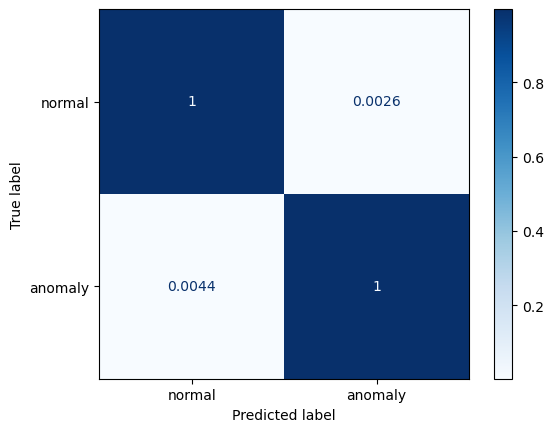

In [42]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
model_train(rf_model)

Accuracy: 0.7517008780601268
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70     11863
           1       0.89      0.71      0.79     22531

    accuracy                           0.75     34394
   macro avg       0.74      0.77      0.74     34394
weighted avg       0.79      0.75      0.76     34394

Confusion Martix: 



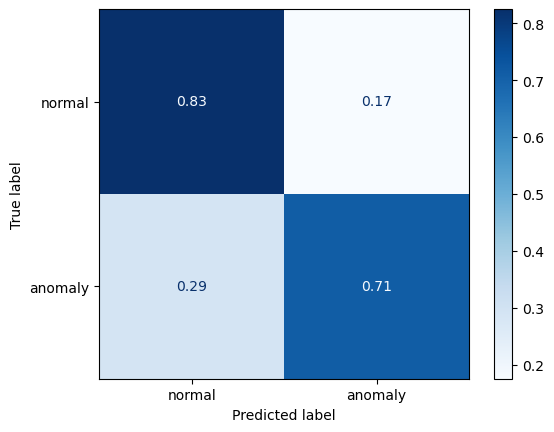

In [44]:
model_test(rf_model)

In [45]:
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 

In [50]:
f_cols = feature_imp_df[feature_imp_df['Gini Importance']>0.01].Feature.values

In [233]:
print(f'Identifying Important Features from Random Forest as : {f_cols}')

Identifying Important Features from Random Forest as : ['flag' 'conn_rate' 'service_encoded' 'error_ratio' 'protocol_type'
 'bytes_ratio' 'avg_duration_per_host' 'rerror_ratio']


Accuracy: 0.9964278626711649
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7998
           1       1.00      1.00      1.00      7119

    accuracy                           1.00     15117
   macro avg       1.00      1.00      1.00     15117
weighted avg       1.00      1.00      1.00     15117

Confusion Martix: 



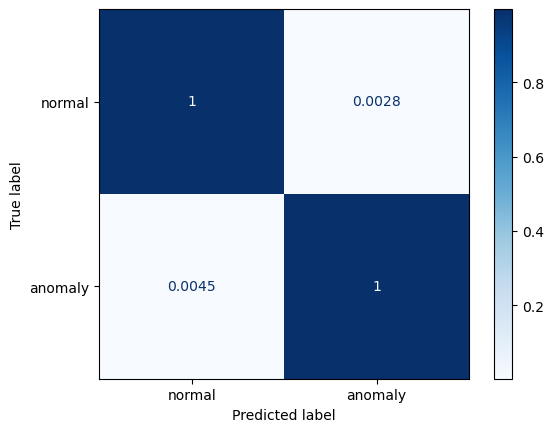

In [54]:
model_train(rf_model, f_cols)

Accuracy: 0.7229458626504623
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.84      0.68     11863
           1       0.89      0.66      0.76     22531

    accuracy                           0.72     34394
   macro avg       0.73      0.75      0.72     34394
weighted avg       0.78      0.72      0.73     34394

Confusion Martix: 



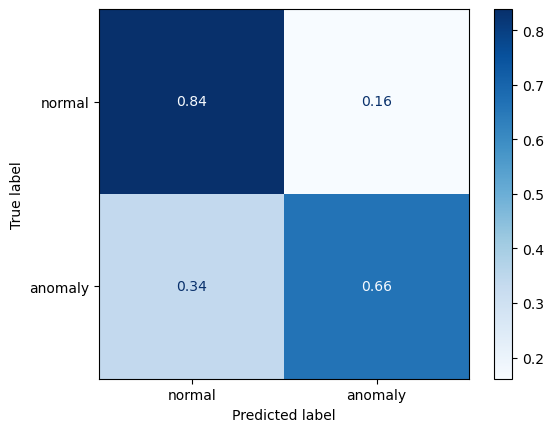

In [55]:
model_test(rf_model, f_cols)

## 2. SVM

In [328]:
svc_model = SVC()

Accuracy: 0.9511807898392538
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      7998
           1       0.98      0.92      0.95      7119

    accuracy                           0.95     15117
   macro avg       0.95      0.95      0.95     15117
weighted avg       0.95      0.95      0.95     15117

Confusion Martix: 



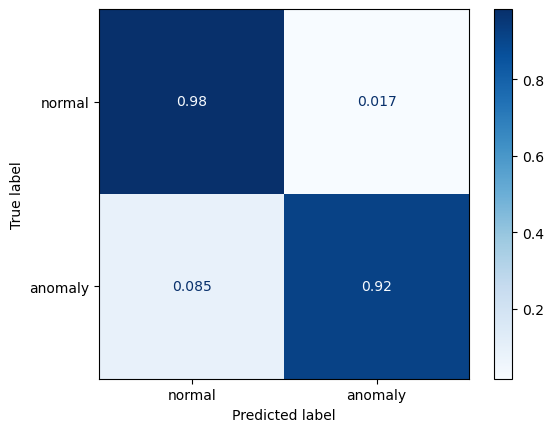

In [329]:
model_train(svc_model)

# KNN

In [331]:
knn_model = KNeighborsClassifier(n_neighbors= 2)

Accuracy: 0.965998544684792
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7998
           1       0.99      0.94      0.96      7119

    accuracy                           0.97     15117
   macro avg       0.97      0.96      0.97     15117
weighted avg       0.97      0.97      0.97     15117

Confusion Martix: 



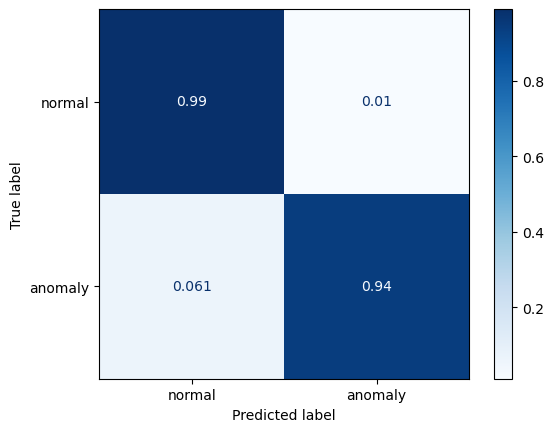

In [335]:
model_train(knn_model, f_cols)

Accuracy: 0.6877943827411758
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.93      0.67     11863
           1       0.94      0.56      0.70     22531

    accuracy                           0.69     34394
   macro avg       0.73      0.75      0.69     34394
weighted avg       0.80      0.69      0.69     34394

Confusion Martix: 



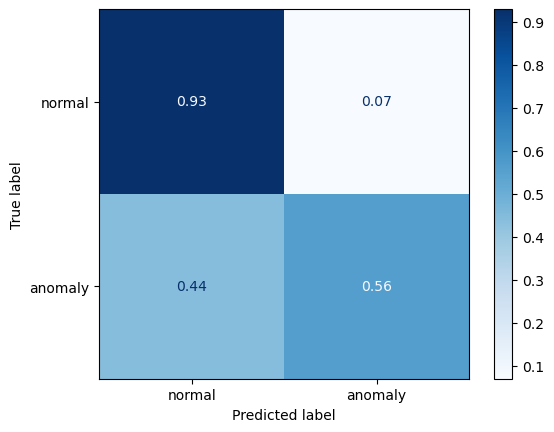

In [336]:
model_test(knn_model, f_cols)

# 4. xgboost

In [58]:
xgb_model = xgb.XGBClassifier(
    max_depth=6,  
    learning_rate=0.03,  
    n_estimators=700,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    gamma=5,  
    reg_lambda=10,  
    eval_metric="logloss",
    reg_alpha=2,  
    random_state=42
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)])

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


[0]	validation_0-logloss:0.66344
[1]	validation_0-logloss:0.63806
[2]	validation_0-logloss:0.61353
[3]	validation_0-logloss:0.58995
[4]	validation_0-logloss:0.56755
[5]	validation_0-logloss:0.54632
[6]	validation_0-logloss:0.52757
[7]	validation_0-logloss:0.50934
[8]	validation_0-logloss:0.49138
[9]	validation_0-logloss:0.47477
[10]	validation_0-logloss:0.45845
[11]	validation_0-logloss:0.44260
[12]	validation_0-logloss:0.42862
[13]	validation_0-logloss:0.41415
[14]	validation_0-logloss:0.40043
[15]	validation_0-logloss:0.38715
[16]	validation_0-logloss:0.37549
[17]	validation_0-logloss:0.36341
[18]	validation_0-logloss:0.35161
[19]	validation_0-logloss:0.34130
[20]	validation_0-logloss:0.33113
[21]	validation_0-logloss:0.32162
[22]	validation_0-logloss:0.31175
[23]	validation_0-logloss:0.30226
[24]	validation_0-logloss:0.29314
[25]	validation_0-logloss:0.28435
[26]	validation_0-logloss:0.27646
[27]	validation_0-logloss:0.26833
[28]	validation_0-logloss:0.26032
[29]	validation_0-loglos

Accuracy: 0.9966263147449891
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7998
           1       1.00      0.99      1.00      7119

    accuracy                           1.00     15117
   macro avg       1.00      1.00      1.00     15117
weighted avg       1.00      1.00      1.00     15117

Confusion Martix: 



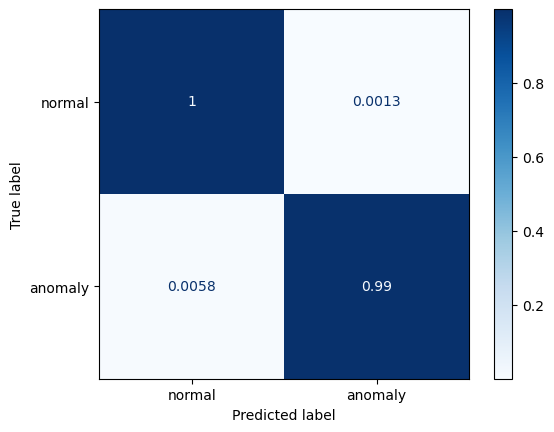

In [60]:
model_train(xgb_model, f_cols)

Accuracy: 0.5147118683491306
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.07      0.09     11863
           1       0.60      0.75      0.67     22531

    accuracy                           0.51     34394
   macro avg       0.36      0.41      0.38     34394
weighted avg       0.44      0.51      0.47     34394

Confusion Martix: 



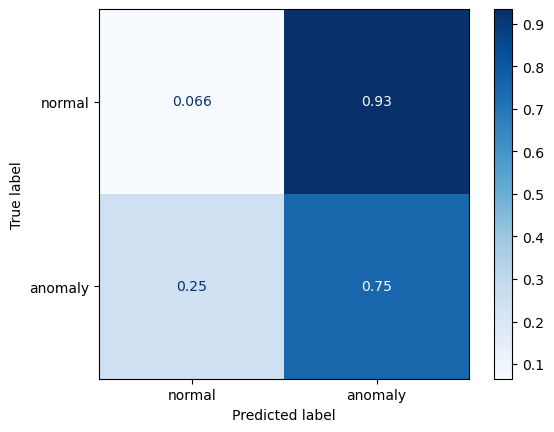

In [62]:
model_test(xgb_model, f_cols)

# Unsupervised model

In [354]:
f_cols

array(['flag', 'conn_rate', 'service_encoded', 'error_ratio',
       'protocol_type', 'bytes_ratio', 'count_10s', 'rerror_ratio',
       'avg_duration_per_host', 'traffic_spike'], dtype=object)

In [356]:
unsupervised_data = train_data[cols].drop(columns = ['class'])[f_cols]
final_class = train_data['class']

## 1. isolation forest

In [359]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.05, random_state=42)
unsupervised_data['anomaly_score'] = iso_forest.fit_predict(unsupervised_data)

In [360]:
# Convert predictions (-1: anomaly, 1: normal)
unsupervised_data['anomaly'] = (unsupervised_data['anomaly_score'] == -1).astype(int)

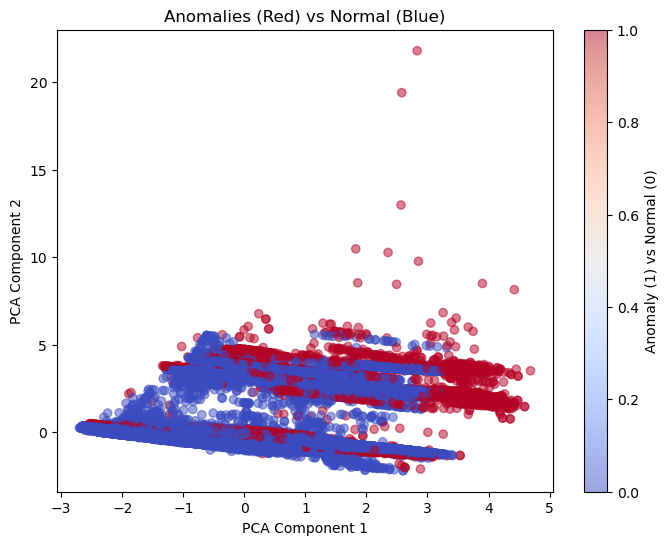

In [361]:
# Reduce dimensions to 2D
unique, counts = np.unique(unsupervised_data['anomaly'], return_counts=True)

unsupervised_data['actual_class'] = final_class.astype(int)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(unsupervised_data.drop(columns= ['anomaly']))

# Plot anomalies vs. normal
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=unsupervised_data['anomaly'], cmap='coolwarm', alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Anomalies (Red) vs Normal (Blue)")
plt.colorbar(label="Anomaly (1) vs Normal (0)")
plt.show()


High overlapping in Red and Blue: there is high Misclassification chance

In [363]:
# Result Analysis
y_true = final_class.astype(int)
y_pred = unsupervised_data['anomaly']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")
print(f"🔹 ROC-AUC: {roc_auc:.4f}")


🔹 Accuracy: 0.5611
🔹 Precision: 0.7664
🔹 Recall: 0.0823
🔹 F1-score: 0.1487
🔹 ROC-AUC: 0.5302


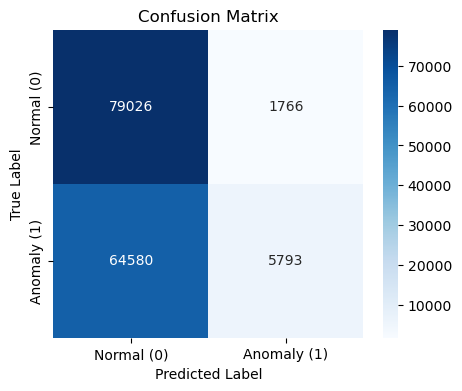

In [368]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal (0)", "Anomaly (1)"], 
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

* Low performance on classification matrix

# 2. K means algorithm

In [370]:
unsupervised_data = unsupervised_data[unsupervised_data.columns[:-3]]

In [372]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
unsupervised_data["cluster"] = kmeans.fit_predict(unsupervised_data)

In [373]:
unsupervised_data

,flag,conn_rate,service_encoded,error_ratio,protocol_type,bytes_ratio,count_10s,rerror_ratio,avg_duration_per_host,traffic_spike,cluster
0,0,-0.715468,0.054616,-0.643616,2,-0.007163,-1.279474,-0.374201,0.018336,3.086844,0
1,0,-0.619088,0.034512,-0.643616,1,-0.007227,-1.262682,-0.374201,0.670957,4.800012,0
2,1,0.344708,0.173347,1.576445,2,-0.007253,-1.074913,-0.374201,0.670957,5.219494,1
3,0,-0.689182,0.319790,0.096404,2,-0.007253,-1.274895,-0.374201,-1.447379,4.177042,0
4,0,-0.470138,0.319790,-0.643616,2,-0.007253,-1.029115,-0.374201,0.670957,5.228071,0
...,...,...,...,...,...,...,...,...,...,...,...
151160,1,0.879177,0.173347,1.576445,2,-0.007253,-0.233767,-0.374201,0.670957,-0.657176,1
151161,0,-0.731044,0.173347,-0.643616,1,-0.007253,-0.232241,-0.374201,0.670957,-0.653981,0
151162,0,-0.724229,0.057963,-0.643616,2,-0.007252,-0.397111,-0.374201,0.670957,-0.743704,0
151163,1,0.528706,0.003473,1.576445,2,-0.007253,-0.181863,-0.374201,0.670957,-0.606687,1


In [376]:
y_true = final_class.astype(int)  # Ground truth labels
y_pred = unsupervised_data["cluster"]  # K-Means anomaly labels

print(f"🔹 Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"🔹 Precision: {precision_score(y_true, y_pred):.4f}")
print(f"🔹 Recall: {recall_score(y_true, y_pred):.4f}")
print(f"🔹 F1-score: {f1_score(y_true, y_pred):.4f}")
# print(f"🔹 Silhouette Score: {silhouette_score(unsupervised_data, unsupervised_data['cluster']):.4f}")

🔹 Accuracy: 0.8826
🔹 Precision: 0.9333
🔹 Recall: 0.8053
🔹 F1-score: 0.8646


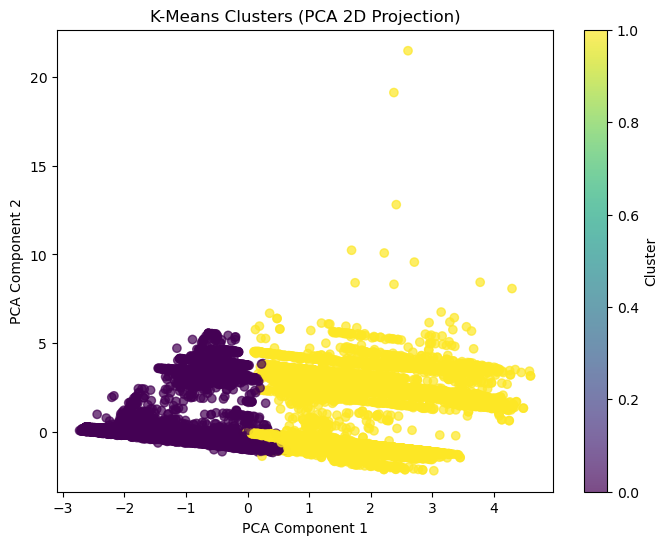

In [378]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(unsupervised_data)

# Scatter plot of clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=unsupervised_data['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.show()


* The clusters are well-separated, suggesting that the data naturally divides into two groups.

# deep learning

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout

In [382]:
model = Sequential([
    Dense(32, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Dropout for regularization
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [384]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 32)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

print(class_weights)  # Check computed weights


{0: 0.9343911804060736, 1: 1.0755181303780093}


In [386]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
model.compile(optimizer=adam
              , loss='binary_focal_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=5, verbose=1, )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

callbacks = [ reduce_lr, early_stop]
#class_weights = {0: 1, 1: 4}  # Correct: Integer keys


In [388]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val),
                   callbacks = callbacks)

Epoch 1/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9007 - loss: 0.0669 - val_accuracy: 0.9472 - val_loss: 0.0433 - learning_rate: 0.0025
Epoch 2/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9453 - loss: 0.0447 - val_accuracy: 0.9471 - val_loss: 0.0408 - learning_rate: 0.0025
Epoch 3/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9475 - loss: 0.0419 - val_accuracy: 0.9514 - val_loss: 0.0386 - learning_rate: 0.0025
Epoch 4/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9495 - loss: 0.0399 - val_accuracy: 0.9514 - val_loss: 0.0379 - learning_rate: 0.0025
Epoch 5/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9509 - loss: 0.0396 - val_accuracy: 0.9529 - val_loss: 0.0360 - learning_rate: 0.0025
Epoch 6/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9517 - loss: 0.0368 - val_accuracy: 0.9642 - val_loss: 0.0312 - learning_rate: 0.0025
Epoch 7/30
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9598 - 

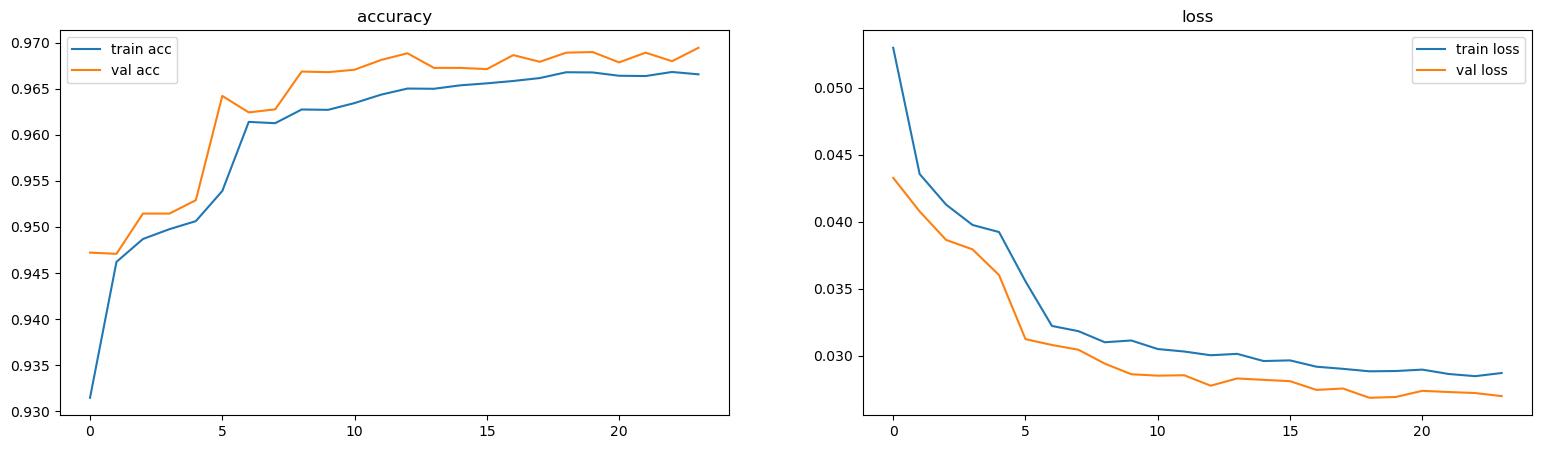

In [394]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('loss')
plt.legend()

In [396]:
from sklearn.metrics import precision_recall_curve

In [398]:
model_y_pred = model.predict(X_val)

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [399]:
precision, recall, thresholds = precision_recall_curve(y_val, model_y_pred)

In [403]:
model_y_pred = model.predict(X_val)

model_y_pred_int =[]
for i in model_y_pred:
    if i>0.5:
        model_y_pred_int.append(1)
    else:
        model_y_pred_int.append(0)

print(classification_report(y_val, model_y_pred_int))

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7998
           1       0.99      0.94      0.97      7119

    accuracy                           0.97     15117
   macro avg       0.97      0.97      0.97     15117
weighted avg       0.97      0.97      0.97     15117



In [405]:
model_yt_pred = model.predict(X_test)

model_yt_pred_int =[]
for i in model_yt_pred:
    if i>0.45:
        model_yt_pred_int.append(1)
    else:
        model_yt_pred_int.append(0)


print(classification_report(y_test, model_yt_pred_int))

1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.57      0.97      0.72     11863
           1       0.98      0.62      0.76     22531

    accuracy                           0.74     34394
   macro avg       0.78      0.80      0.74     34394
weighted avg       0.84      0.74      0.75     34394



# improving nn

In [264]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Build fixed model
model = Sequential([
    Dense(64, activation='swish', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Small dropout

    Dense(32, activation='swish', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(16, activation='swish'),
    Dense(8, activation='swish'),
    Dense(1, activation='sigmoid')
])

# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # Reduce LR for stability
model.compile(optimizer=adam, loss='binary_focal_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stop])


Epoch 1/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8849 - loss: 0.1134 - val_accuracy: 0.9377 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 2/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9336 - loss: 0.0628 - val_accuracy: 0.9369 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 3/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9357 - loss: 0.0591 - val_accuracy: 0.9356 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 4/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9377 - loss: 0.0558 - val_accuracy: 0.9340 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 5/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9392 - loss: 0.0542 - val_accuracy: 0.9378 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 6/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9398 - loss: 0.0532 - val_accuracy: 0.9368 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 7/30
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9415 - l

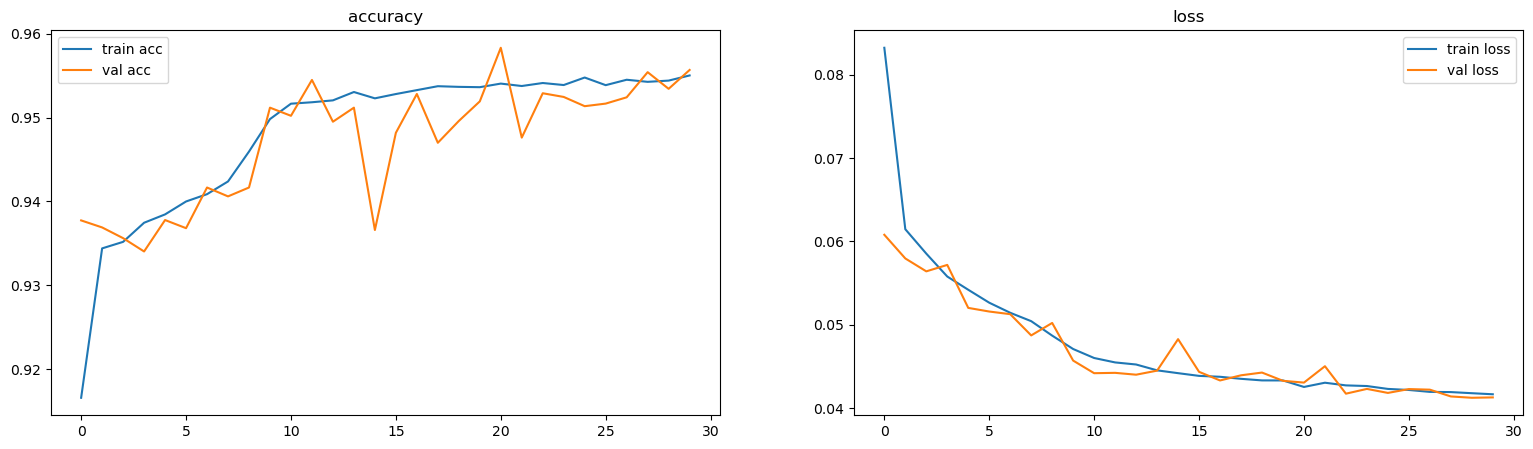

In [266]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('loss')
plt.legend()

In [268]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get probabilities
y_probs = model.predict(X_val)
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Find best F1 threshold
f1_scores = (2 * precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_threshold}")

# Apply best threshold
y_pred_int = (y_probs > best_threshold).astype(int)
print(classification_report(y_val, y_pred_int))


709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold: 0.39695972204208374
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12036
           1       0.95      0.96      0.96     10639

    accuracy                           0.96     22675
   macro avg       0.96      0.96      0.96     22675
weighted avg       0.96      0.96      0.96     22675



In [278]:
# Get probabilities
yt_probs = model.predict(X_test)

# Apply best threshold
yt_pred_int = (yt_probs > best_threshold).astype(int)
print(classification_report(y_test, yt_pred_int))


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.60      0.83      0.70     11863
           1       0.89      0.71      0.79     22531

    accuracy                           0.75     34394
   macro avg       0.74      0.77      0.74     34394
weighted avg       0.79      0.75      0.76     34394



In [282]:
model.save('dnn_0_4.h5')
model.save_weights('WT_dnn_0_4.weights.h5')

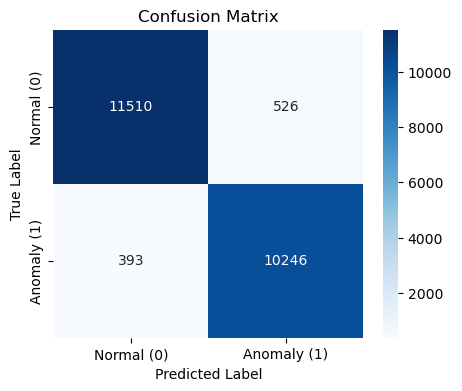

In [290]:
cm = confusion_matrix(y_val, y_pred_int)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal (0)", "Anomaly (1)"], 
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [298]:
y_test[y_test==0].shape

(11863,)

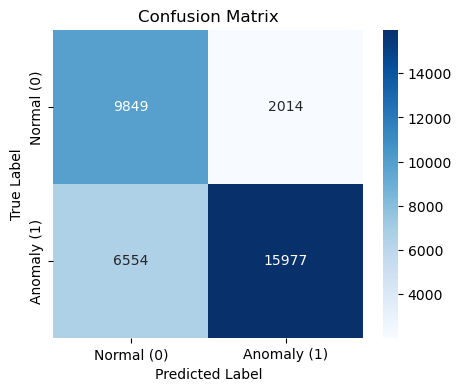

In [288]:
cm = confusion_matrix(y_test, yt_pred_int)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal (0)", "Anomaly (1)"], 
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# lIMITED FEATS

In [407]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Build fixed model
model = Sequential([
    Dense(64, activation='swish', kernel_regularizer=l2(0.001), input_shape=(X_train[f_cols].shape[1],)),
    Dropout(0.2),  # Small dropout

    Dense(32, activation='swish', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(16, activation='swish', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(8, activation='swish'),
    Dense(1, activation='sigmoid')
])

# Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # Reduce LR for stability
model.compile(optimizer=adam, loss='binary_focal_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train[f_cols], y_train, epochs=30, batch_size=128, 
                        validation_data=(X_val[f_cols], y_val),
                        callbacks=[reduce_lr, early_stop])


Epoch 1/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9034 - loss: 0.1188 - val_accuracy: 0.9391 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 2/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9360 - loss: 0.0648 - val_accuracy: 0.9385 - val_loss: 0.0606 - learning_rate: 0.0010
Epoch 3/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9370 - loss: 0.0617 - val_accuracy: 0.9393 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 4/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9365 - loss: 0.0606 - val_accuracy: 0.9398 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 5/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9377 - loss: 0.0592 - val_accuracy: 0.9389 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 6/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9377 - loss: 0.0591 - val_accuracy: 0.9400 - val_loss: 0.0577 - learning_rate: 0.0010
Epoch 7/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9376 - 

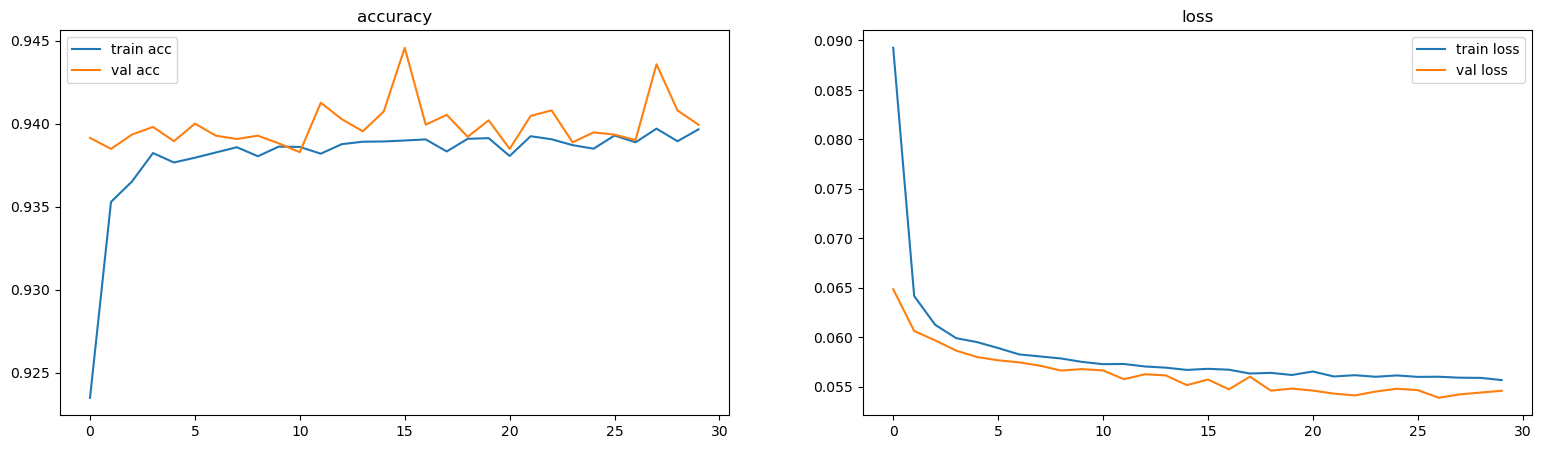

In [409]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('loss')
plt.legend()

In [425]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get probabilities
y_probs = model.predict(X_val[f_cols])
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Find best F1 threshold
f1_scores = (2 * precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_threshold}")

# Apply best threshold
y_pred_int = (y_probs > 0.5).astype(int)
print(classification_report(y_val, y_pred_int))


473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold: 0.5457249283790588
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7998
           1       0.96      0.91      0.93      7119

    accuracy                           0.94     15117
   macro avg       0.94      0.94      0.94     15117
weighted avg       0.94      0.94      0.94     15117



In [427]:
# Get probabilities
yt_probs = model.predict(X_test[f_cols])

# Apply best threshold
yt_pred_int = (yt_probs > 0.5).astype(int)
print(classification_report(y_test, yt_pred_int))


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.54      0.97      0.70     11863
           1       0.98      0.57      0.72     22531

    accuracy                           0.71     34394
   macro avg       0.76      0.77      0.71     34394
weighted avg       0.83      0.71      0.71     34394



In [292]:
model.save('dnn__v2_0_4.h5')
model.save_weights('WT_dnn_v2_0_4.weights.h5')

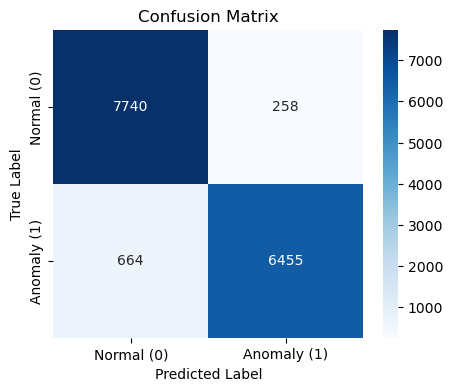

In [482]:
cm = confusion_matrix(y_val, y_pred_int)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal (0)", "Anomaly (1)"], 
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# model tuning -- Final model

In [114]:
def build_nn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_focal_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
input_shape = (len(f_cols),)  # Ensure `f_col` contains the selected features
nn_model = build_nn(input_shape)
nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = nn_model.fit(X_train[f_cols], y_train, epochs=30, batch_size=128, 
                        validation_data=(X_val[f_cols], y_val),
                        callbacks=[reduce_lr, early_stop])

Epoch 1/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9202 - loss: 0.0616 - val_accuracy: 0.9510 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 2/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9506 - loss: 0.0403 - val_accuracy: 0.9626 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 3/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9595 - loss: 0.0340 - val_accuracy: 0.9662 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9647 - loss: 0.0318 - val_accuracy: 0.9680 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 5/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9665 - loss: 0.0299 - val_accuracy: 0.9694 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 6/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9680 - loss: 0.0291 - val_accuracy: 0.9694 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 7/30
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9679 - 

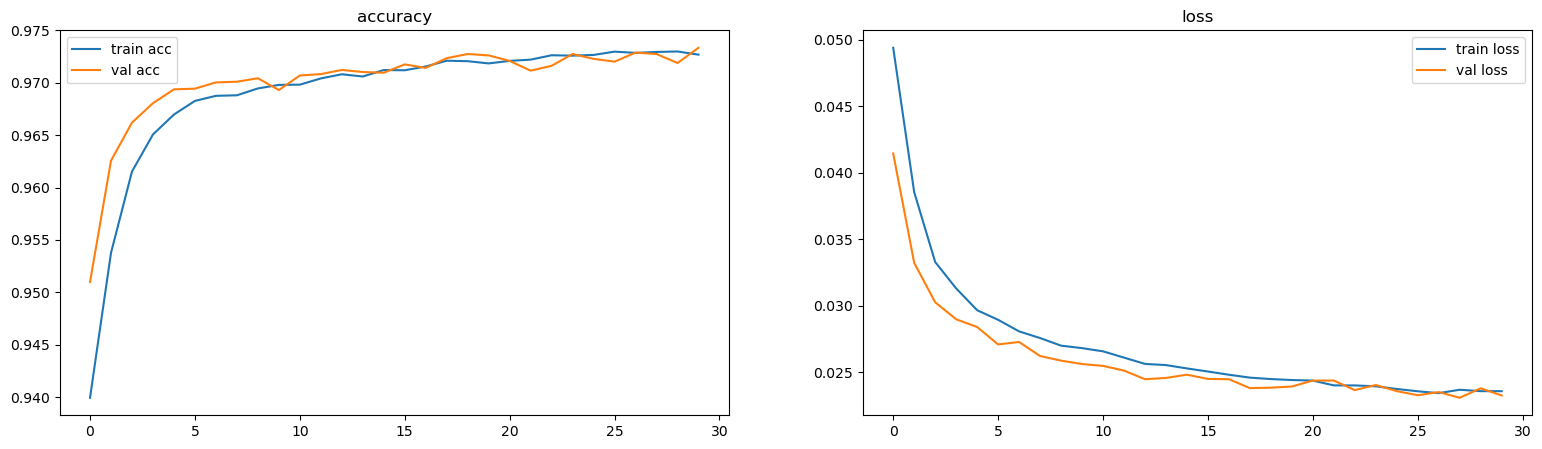

In [118]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('loss')
plt.legend()

In [120]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get probabilities
y_probs = nn_model.predict(X_val[f_cols])
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Find best F1 threshold
f1_scores = (2 * precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_threshold}")

# Apply best threshold
y_pred_int = (y_probs > 0.5).astype(int)
print(classification_report(y_val, y_pred_int))


473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best Threshold: 0.4520833194255829
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7998
           1       0.99      0.95      0.97      7119

    accuracy                           0.97     15117
   macro avg       0.97      0.97      0.97     15117
weighted avg       0.97      0.97      0.97     15117



In [122]:
# Get probabilities
yt_probs = nn_model.predict(X_test[f_cols])

# Apply best threshold
yt_pred_int = (yt_probs > 0.49884340167045593).astype(int)
print(classification_report(y_test, yt_pred_int))


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.53      0.93      0.67     11863
           1       0.94      0.56      0.70     22531

    accuracy                           0.69     34394
   macro avg       0.73      0.74      0.69     34394
weighted avg       0.80      0.69      0.69     34394



In [142]:
nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,565 (135.02 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,044 (90.02 KB)

In [124]:
nn_model.save('final_model.h5')
nn_model.save_weights('final_model.weights.h5')

In [128]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [241]:
import pandas as pd

# Data
data = {
    "Model": [ "Random Forest", "KNN","XGBoost", "Isolation Forest", "K-Means", "Neural Network"],
    "Train Accuracy": ["97%", "97%","96%", "Unsupervised", "Unsupervised",  "92%"],
    "Test Accuracy": ["70%", "69%","56%", "-", "-", "70%"],
    
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


              Model Train Accuracy Test Accuracy
0     Random Forest            97%           70%
1               KNN            97%           69%
2           XGBoost            96%           56%
3  Isolation Forest   Unsupervised             -
4           K-Means   Unsupervised             -
5    Neural Network            92%           70%
